# Project's description:

This project implements an explainable robot advisory service for portfolio management.

It addresses the common "black-box" problem in automated investment tools by using Machine Learning (Random Forest) to predict portfolio performance (Z-score) and then applying SHAP (SHapley Additive exPlanations) values to explain these predictions.

Specifically, it demonstrates how to identify the most influential assets contributing to a portfolio's overall risk-adjusted return.

For this implementation, I utilized historical stock data from Italian financial institutions to construct and analyze daily minimum volatility portfolios using the Markowitz model.

The high R-squared value achieved on the test set indicates the model's strong predictive capability, while the SHAP analysis successfully uncovers the specific contributions of each financial ticker to the portfolio's performance.

This provides crucial transparency, aiming to build trust in automated financial advice.

**WARNING:**

This is for code practice purposes only and it is not supposed to be used in real life by the people who read it.

**Disclaimer**:

This notebook is not a financial advisor.

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
italian_financial_tickers = [
    "ISP.MI",
    "UCG.MI",
    "G.MI",
    "MB.MI",
    "BMED.MI",
    "BAMI.MI",
    "BPE.MI",
    "FBK.MI",
    "BMPS.MI",
    "PST.MI",
    "BGN.MI",
    "CE.MI",
    "BPSO.MI",
    "UNI.MI",
    "AZM.MI"
]

start_date = "2021-01-01"
end_date = "2024-12-31"
rolling_window = 30


print("1. Downloading historical data...")
data = yf.download(italian_financial_tickers, start=start_date, end=end_date)['Close']
data = data.dropna(axis=1, how='all')
data = data.dropna()

if data.empty:
    raise ValueError("No data downloaded. Check tickers and date range.")


returns = data.pct_change().dropna()

print(f"Downloaded data for {len(returns.columns)} assets from {returns.index.min().strftime('%Y-%m-%d')} to {returns.index.max().strftime('%Y-%m-%d')}")
print("Sample returns head:")
print(returns.head())


/tmp/ipython-input-9-2344553701.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(italian_financial_tickers, start=start_date, end=end_date)['Close']
[*************         27%                       ]  4 of 15 completed

1. Downloading historical data...


[*********************100%***********************]  15 of 15 completed


Downloaded data for 15 assets from 2021-01-05 to 2024-12-30
Sample returns head:
Ticker        AZM.MI   BAMI.MI    BGN.MI   BMED.MI   BMPS.MI    BPE.MI  \
Date                                                                     
2021-01-05 -0.010420 -0.000278 -0.018909 -0.025352  0.060928  0.008208   
2021-01-06  0.016221  0.056777  0.009637  0.032514  0.036463  0.053256   
2021-01-07  0.000840  0.030024  0.004405 -0.006298 -0.006156  0.061836   
2021-01-08 -0.001959 -0.007926 -0.006579 -0.004930  0.008849 -0.011222   
2021-01-11 -0.000561 -0.010052 -0.007358  0.002123 -0.021053  0.020552   

Ticker       BPSO.MI     CE.MI    FBK.MI      G.MI    ISP.MI     MB.MI  \
Date                                                                     
2021-01-05 -0.000907 -0.011468 -0.018262 -0.011016 -0.010917  0.003780   
2021-01-06  0.048094  0.013921  0.001116  0.042041  0.033857  0.037924   
2021-01-07  0.019048  0.020595  0.020810 -0.002069  0.010163 -0.002850   
2021-01-08 -0.011895 -0.001121

In [ ]:
print("\n2. Performing daily Markowitz portfolio optimization (minimum volatility)...")

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def daily_markowitz_min_vol_weights(returns_window):
    num_assets = returns_window.shape[1]


    cov_matrix = returns_window.cov() * 252


    if cov_matrix.isnull().values.any() or not np.all(np.isfinite(cov_matrix)):

        return np.ones(num_assets) / num_assets


    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))


    initial_weights = np.array(num_assets * [1. / num_assets,])


    optimal_results = minimize(portfolio_volatility, initial_weights, args=(cov_matrix,),
                               method='SLSQP', bounds=bounds, constraints=constraints)

    if optimal_results.success:
        return optimal_results.x
    else:

        return np.ones(num_assets) / num_assets

portfolio_weights_df = pd.DataFrame(index=returns.index[rolling_window-1:], columns=returns.columns)
portfolio_returns_daily = pd.Series(index=returns.index[rolling_window-1:], dtype=float)
portfolio_risk_daily = pd.Series(index=returns.index[rolling_window-1:], dtype=float)


for i in range(rolling_window - 1, len(returns)):
    window_start_idx = i - (rolling_window - 1)
    window_end_idx = i + 1
    current_window_returns = returns.iloc[window_start_idx:window_end_idx]


    if current_window_returns.shape[0] < rolling_window:
        continue

    current_date = returns.index[i]


    weights = daily_markowitz_min_vol_weights(current_window_returns)
    portfolio_weights_df.loc[current_date] = weights


    current_day_returns = returns.iloc[i].values
    current_cov_matrix = current_window_returns.cov() * 252

    portfolio_daily_return = np.dot(weights, current_day_returns)
    portfolio_daily_risk = np.sqrt(np.dot(weights.T, np.dot(current_cov_matrix, weights)))

    portfolio_returns_daily.loc[current_date] = portfolio_daily_return
    portfolio_risk_daily.loc[current_date] = portfolio_daily_risk


portfolio_weights_df = portfolio_weights_df.dropna()
portfolio_returns_daily = portfolio_returns_daily.dropna()
portfolio_risk_daily = portfolio_risk_daily.dropna()

print("Sample portfolio weights head:")
print(portfolio_weights_df.head())
print("Sample portfolio daily returns head:")
print(portfolio_returns_daily.head())
print("Sample portfolio daily risk head:")
print(portfolio_risk_daily.head())



2. Performing daily Markowitz portfolio optimization (minimum volatility)...
Sample portfolio weights head:
Ticker     AZM.MI BAMI.MI    BGN.MI BMED.MI BMPS.MI BPE.MI BPSO.MI CE.MI  \
Date                                                                       
2021-02-15    0.0     0.0  0.334449     0.0     0.0    0.0     0.0   0.0   
2021-02-16    0.0     0.0  0.341612     0.0     0.0    0.0     0.0   0.0   
2021-02-17    0.0     0.0  0.066645     0.0     0.0    0.0     0.0   0.0   
2021-02-18    0.0     0.0  0.064873     0.0     0.0    0.0     0.0   0.0   
2021-02-19    0.0     0.0  0.049323     0.0     0.0    0.0     0.0   0.0   

Ticker        FBK.MI      G.MI ISP.MI     MB.MI PST.MI UCG.MI UNI.MI  
Date                                                                  
2021-02-15  0.111378  0.506489    0.0  0.047683    0.0    0.0    0.0  
2021-02-16  0.132503  0.525885    0.0       0.0    0.0    0.0    0.0  
2021-02-17       0.0  0.840658    0.0  0.092698    0.0    0.0    0.0  
202

In [ ]:
print("\n3. Calculating Z-scores for individual assets and portfolio...")


common_index = portfolio_weights_df.index.intersection(returns.index)
returns_aligned = returns.loc[common_index]
portfolio_weights_df_aligned = portfolio_weights_df.loc[common_index]
portfolio_returns_daily_aligned = portfolio_returns_daily.loc[common_index]
portfolio_risk_daily_aligned = portfolio_risk_daily.loc[common_index]


individual_asset_z_scores = pd.DataFrame(index=returns_aligned.index, columns=returns_aligned.columns)

for i in range(len(returns_aligned)):
    current_date = returns_aligned.index[i]


    if i < rolling_window:
        continue

    historical_returns_window = returns_aligned.iloc[i - rolling_window : i]


    mean_returns_window = historical_returns_window.mean()
    std_dev_returns_window = historical_returns_window.std()


    current_day_actual_returns = returns_aligned.loc[current_date]


    std_dev_returns_window_safe = std_dev_returns_window.replace(0, np.nan)
    asset_z_scores = (current_day_actual_returns - mean_returns_window) / std_dev_returns_window_safe

    individual_asset_z_scores.loc[current_date] = asset_z_scores

individual_asset_z_scores = individual_asset_z_scores.dropna(how='all')
individual_asset_z_scores = individual_asset_z_scores.fillna(0)

print("Sample individual asset Z-scores head:")
print(individual_asset_z_scores.head())



portfolio_z_scores = pd.Series(index=portfolio_returns_daily_aligned.index, dtype=float)

for i in range(len(portfolio_returns_daily_aligned)):
    current_date = portfolio_returns_daily_aligned.index[i]

    if i < rolling_window:
        continue


    historical_portfolio_returns_window = portfolio_returns_daily_aligned.iloc[i - rolling_window : i]
    historical_portfolio_risk_window = portfolio_risk_daily_aligned.iloc[i - rolling_window : i]

    mean_portfolio_return_window = historical_portfolio_returns_window.mean()
    std_dev_portfolio_return_window = historical_portfolio_returns_window.std()


    current_day_actual_portfolio_return = portfolio_returns_daily_aligned.loc[current_date]

    if std_dev_portfolio_return_window > 0:
        portfolio_z_scores.loc[current_date] = (current_day_actual_portfolio_return - mean_portfolio_return_window) / std_dev_portfolio_return_window
    else:
        portfolio_z_scores.loc[current_date] = 0

portfolio_z_scores = portfolio_z_scores.dropna()
print("Sample portfolio Z-scores head:")
print(portfolio_z_scores.head())


common_ml_index = individual_asset_z_scores.index.intersection(portfolio_z_scores.index)
X = individual_asset_z_scores.loc[common_ml_index]
y = portfolio_z_scores.loc[common_ml_index]

if X.empty or y.empty:
    raise ValueError("Not enough aligned data for Machine Learning. Check data ranges and window size.")

print(f"\nData ready for ML: X shape {X.shape}, y shape {y.shape}")



3. Calculating Z-scores for individual assets and portfolio...


/tmp/ipython-input-11-1917581825.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  individual_asset_z_scores = individual_asset_z_scores.fillna(0) # Fill remaining NaNs (e.g., std=0) with 0, implying no deviation


Sample individual asset Z-scores head:
Ticker        AZM.MI   BAMI.MI    BGN.MI   BMED.MI   BMPS.MI    BPE.MI  \
Date                                                                     
2021-03-29  0.312257 -0.001423  0.037937 -0.303935 -0.040346 -0.595601   
2021-03-30  1.511854  1.175157  0.431351  0.782933  1.188430  0.017623   
2021-03-31 -0.651559 -1.909751 -1.160779 -0.454907 -0.567963 -0.677869   
2021-04-01 -0.004113 -0.096973  0.010742 -0.370312  3.896654  0.636513   
2021-04-06  0.359383 -0.495789  1.023290  0.185696  0.254503 -0.185377   

Ticker       BPSO.MI     CE.MI    FBK.MI      G.MI    ISP.MI     MB.MI  \
Date                                                                     
2021-03-29 -0.637979  0.288722 -0.408167  0.544605 -0.785645  0.034641   
2021-03-30  2.082941  0.880760  1.232397  0.218605  1.333246  0.931050   
2021-03-31 -2.008788 -1.594625 -0.066141 -0.778706 -0.832601 -1.725055   
2021-04-01  0.544598 -0.217076  0.158389 -0.484818 -0.005695 -0.059578  

In [ ]:
print("\n4. Training Random Forest model...")


train_size = int(0.7 * len(X))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]


model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

print(f"Random Forest model trained on {len(X_train)} samples.")
print(f"R-squared on test set: {model.score(X_test, y_test):.4f}")



4. Training Random Forest model...
Random Forest model trained on 671 samples.
R-squared on test set: 0.8224



5. Applying SHAP values for explainability...

Mean Absolute SHAP values (Global Feature Importance):
    Feature  Mean_Abs_SHAP_Value
9      G.MI             0.367224
11    MB.MI             0.152667
10   ISP.MI             0.144921
3   BMED.MI             0.077546
7     CE.MI             0.075121
14   UNI.MI             0.073526
2    BGN.MI             0.052698
4   BMPS.MI             0.038478
0    AZM.MI             0.024374
13   UCG.MI             0.019438
12   PST.MI             0.018726
6   BPSO.MI             0.017042
8    FBK.MI             0.011488
5    BPE.MI             0.009555
1   BAMI.MI             0.006971


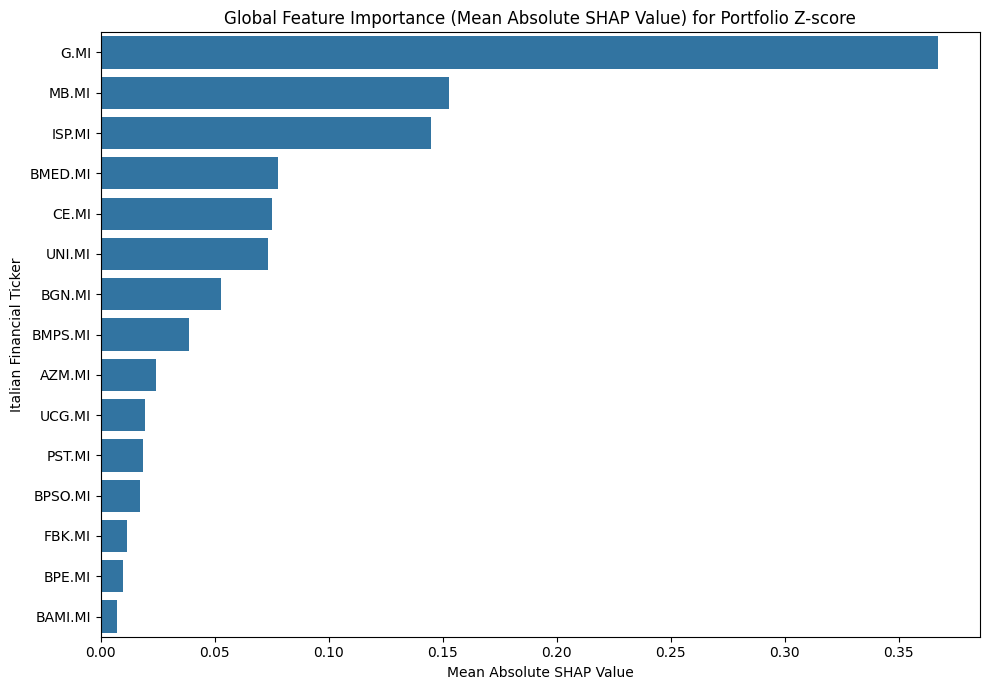


--- Implementation Complete ---


In [ ]:
print("\n5. Applying SHAP values for explainability...")


explainer = shap.TreeExplainer(model)


shap_values = explainer.shap_values(X_test)


shap_summary = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean_Abs_SHAP_Value': np.abs(shap_values).mean(axis=0)
})
shap_summary = shap_summary.sort_values(by='Mean_Abs_SHAP_Value', ascending=False)

print("\nMean Absolute SHAP values (Global Feature Importance):")
print(shap_summary)


plt.figure(figsize=(10, 7))
sns.barplot(x='Mean_Abs_SHAP_Value', y='Feature', data=shap_summary)
plt.title('Global Feature Importance (Mean Absolute SHAP Value) for Portfolio Z-score')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Italian Financial Ticker')
plt.tight_layout()
plt.show()

print("\n--- Implementation Complete ---")

# **Commenting the results:**

G.MI is the Dominant Factor:

Its Mean Absolute SHAP value (0.367224) is significantly higher than any other asset, indicating that the risk-adjusted performance (Z-score) of G.MI is by far the most influential factor in explaining the overall predicted portfolio Z-score by the Random Forest model.

This means changes in G.MI's Z-score will have the largest average impact on the portfolio's predicted Z-score.

**Top Tier Influencers** (G.MI, MB.MI, ISP.MI):

Following G.MI, MB.MI and ISP.MI are the next most important features.

These three Italian financial institutions collectively drive a large portion of the model's explanation for the portfolio's performance.

**Tiered Importance:**

The remaining assets show a clear hierarchy of influence, with some having moderate impact (e.g., BMED.MI, CE.MI, UNI.MI) and others having very minimal average impact on the model's predictions (e.g., BAMI.MI, BPE.MI, FBK.MI).

**Final oberservations:**

In summary, this SHAP result is excellent because it directly provides the desired explainability, a critical component for increasing the adoption and reliability of robot advisory services in the financial sector.

However this experiment was written only in order to practice with code and it is not a financial advisor.